# The image depicts a decoder-only Transformer architecture, similar to models like GPT. It consists of:

### Input Embedding + Positional Encoding
### A stack of Transformer Blocks (Decoder Blocks)
### Each Transformer Block has:
### Masked Multi-Head Self-Attention
### Add & Norm (Residual Connection + Layer Normalization)
### Feed-Forward Network
### Add & Norm
### Final Layer Normalization
### Linear layer (to project to vocabulary size)
### Softmax (to get probabilities)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import requests # For downloading Shakespeare
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2LMHeadModel, GPT2Config
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import Trainer, TrainingArguments

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## 1. Token & Position Embedding
Token Embedding: Converts input tokens (integers representing words/subwords/characters) into dense vector representations.
Position Embedding: Adds information about the position of each token in the sequence, as the self-attention mechanism itself is permutation-invariant.

Shape of embedded output: torch.Size([1, 5, 32])


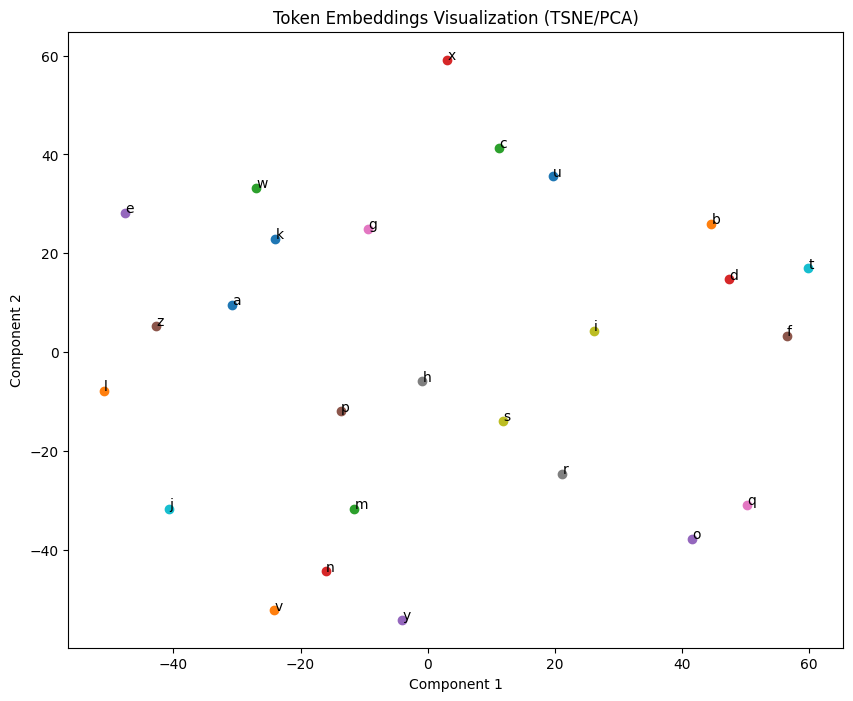

In [2]:
class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, block_size):
        """
        Args:
            vocab_size (int): Number of unique tokens in the vocabulary.
            embed_dim (int): Dimensionality of the token and position embeddings.
            block_size (int): Maximum sequence length the model can handle (context window).
        """
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(block_size, embed_dim)
        self.embed_dim = embed_dim
        self.block_size = block_size

    def forward(self, idx):
        """
        Args:
            idx (torch.Tensor): Input tensor of token indices, shape (batch_size, seq_len).
        Returns:
            torch.Tensor: Combined token and position embeddings, shape (batch_size, seq_len, embed_dim).
        """
        B, T = idx.shape
        if T > self.block_size:
            raise ValueError(f"Input sequence length ({T}) exceeds block_size ({self.block_size})")

        tok_emb = self.token_embedding(idx)  # (B, T, embed_dim)

        # Create position indices: 0, 1, 2, ..., T-1
        pos_idx = torch.arange(T, device=idx.device).unsqueeze(0) # (1, T)
        pos_emb = self.position_embedding(pos_idx) # (1, T, embed_dim)

        # Add token and position embeddings (broadcasting pos_emb across batch)
        x = tok_emb + pos_emb
        return x

# --- Configuration for our simplified model ---
VOCAB_SIZE = 65 # Example: For character-level Shakespeare (26 lowercase, 26 upper, 10 digits, space, newline, punctuation)
EMBED_DIM = 128 # Reduced from GPT-2's 768 for faster training
BLOCK_SIZE = 64 # Max context length, reduced from 1024
# --- End Configuration ---

# Example Usage & Visualization
sample_vocab = {chr(i+97): i for i in range(26)} # a-z
sample_vocab_size = len(sample_vocab)
sample_embed_dim = 32 # Small for visualization
sample_block_size = 10

embedding_layer = TokenAndPositionEmbedding(sample_vocab_size, sample_embed_dim, sample_block_size).to(device)

# Create some sample token indices
sample_text = "hello"
sample_indices = torch.tensor([[sample_vocab[c] for c in sample_text]], dtype=torch.long).to(device)

embedded_output = embedding_layer(sample_indices)
print("Shape of embedded output:", embedded_output.shape)

# Visualization: Plot token embedding (PCA/TSNE)
# We'll visualize the token embeddings directly from the nn.Embedding layer
token_embeddings_matrix = embedding_layer.token_embedding.weight.data.cpu().numpy()

if sample_vocab_size > 2 and sample_embed_dim > 1 : # PCA/TSNE need at least 2 samples and 2 features
    if token_embeddings_matrix.shape[0] > 1 and token_embeddings_matrix.shape[1] > 1: # Ensure enough data for PCA/TSNE
        if token_embeddings_matrix.shape[0] > 2 and token_embeddings_matrix.shape[1] > 2 : # TSNE prefers n_samples > n_components
            tsne = TSNE(n_components=2, perplexity=min(5, sample_vocab_size-1), random_state=42, init='pca', learning_rate='auto')
            reduced_embeddings = tsne.fit_transform(token_embeddings_matrix)
        else:
            pca = PCA(n_components=2)
            reduced_embeddings = pca.fit_transform(token_embeddings_matrix)

        plt.figure(figsize=(10, 8))
        for i, char_code in enumerate(sample_vocab.values()):
            char = [k for k, v in sample_vocab.items() if v == char_code][0]
            plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1])
            plt.text(reduced_embeddings[i, 0]+0.05, reduced_embeddings[i, 1]+0.05, char)
        plt.title("Token Embeddings Visualization (TSNE/PCA)")
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.show()
    else:
        print("Not enough data points or dimensions for PCA/TSNE visualization of token embeddings.")
else:
    print("Vocab size or embed_dim too small for meaningful PCA/TSNE visualization.")

Question: We add or concatenate position embedding here?
### Answer: In the standard Transformer architecture (Vaswani et al., 2017) and GPT-like models, the positional embeddings are added to the token embeddings. The provided diagram also shows an addition operation (+) combining "Input Embedding" and "Positional Encoding". Adding them allows the model to learn a combined representation where position influences the token's vector. Concatenation would increase the dimensionality and require subsequent layers to learn how to merge this information.

# 2. Multi-Head Attention
Multi-Head Attention (MHA) allows the model to jointly attend to information from different representation subspaces at different positions.

Shape of MHA output: torch.Size([1, 5, 128])
Shape of attention weights: torch.Size([1, 4, 5, 5])


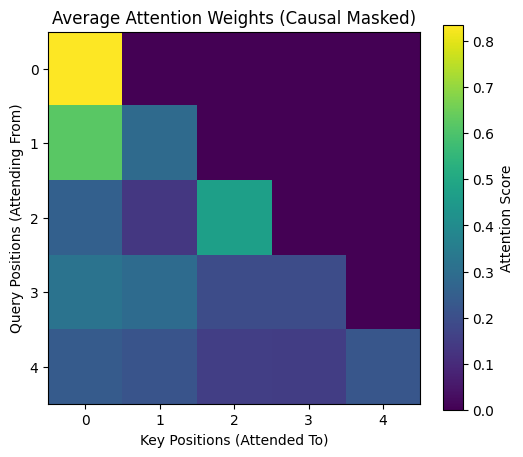

In [3]:
class Head(nn.Module):
    """One head of self-attention"""
    def __init__(self, embed_dim, head_size, block_size, dropout_rate):
        super().__init__()
        self.key = nn.Linear(embed_dim, head_size, bias=False)
        self.query = nn.Linear(embed_dim, head_size, bias=False)
        self.value = nn.Linear(embed_dim, head_size, bias=False)
        # tril is not a parameter, but a buffer. So register it.
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout_rate)
        self.head_size = head_size

    def forward(self, x, return_attention_weights=False):
        B, T, C = x.shape # Batch, Time (seq_len), Channels (embed_dim)
        k = self.key(x)   # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)
        v = self.value(x) # (B, T, head_size)

        # Compute attention scores ("affinities")
        # (B, T, head_size) @ (B, head_size, T) -> (B, T, T)
        wei = q @ k.transpose(-2, -1) * (self.head_size**-0.5)

        # Apply causal mask (for decoder)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)

        attn_weights = F.softmax(wei, dim=-1) # (B, T, T)
        attn_weights = self.dropout(attn_weights)

        # Perform weighted aggregation of values
        out = attn_weights @ v # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)

        if return_attention_weights:
            return out, attn_weights
        return out

class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel"""
    def __init__(self, num_heads, embed_dim, block_size, dropout_rate):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        head_size = embed_dim // num_heads
        self.heads = nn.ModuleList([Head(embed_dim, head_size, block_size, dropout_rate) for _ in range(num_heads)])
        self.proj = nn.Linear(embed_dim, embed_dim) # Projection back to residual pathway
        self.dropout = nn.Dropout(dropout_rate)
        self.num_heads = num_heads

    def forward(self, x, return_attention_weights=False):
        # x: (B, T, C)
        head_outputs = []
        all_attn_weights = [] # To store attention weights from each head for visualization

        for head_idx, head_module in enumerate(self.heads):
            if return_attention_weights:
                out, attn = head_module(x, return_attention_weights=True)
                head_outputs.append(out)
                all_attn_weights.append(attn.unsqueeze(1)) # Add a head dimension: (B, 1, T, T)
            else:
                head_outputs.append(head_module(x))

        # Concatenate head outputs along the last dimension (channel/feature dimension)
        # Each head_output is (B, T, head_size). Concatenating num_heads of them gives (B, T, num_heads * head_size) = (B, T, embed_dim)
        concatenated_heads = torch.cat(head_outputs, dim=-1)

        out = self.dropout(self.proj(concatenated_heads))

        if return_attention_weights:
            # Stack attention weights: (B, num_heads, T, T)
            all_attn_weights_stacked = torch.cat(all_attn_weights, dim=1)
            return out, all_attn_weights_stacked
        return out

# --- Configuration ---
NUM_HEADS = 4 # Number of attention heads
DROPOUT_RATE = 0.1 # Dropout rate
# --- End Configuration ---

# Example Usage & Visualization
mha = MultiHeadAttention(num_heads=NUM_HEADS, embed_dim=EMBED_DIM, block_size=BLOCK_SIZE, dropout_rate=DROPOUT_RATE).to(device)
embedding_layer_full = TokenAndPositionEmbedding(VOCAB_SIZE, EMBED_DIM, BLOCK_SIZE).to(device)

# Create a sample input sequence (batch_size=1, seq_len=5)
sample_input_indices = torch.randint(0, VOCAB_SIZE, (1, 5)).to(device)
sample_embeddings = embedding_layer_full(sample_input_indices) # (1, 5, EMBED_DIM)

# Get MHA output and attention weights
mha_output, attention_weights = mha(sample_embeddings, return_attention_weights=True)
print("Shape of MHA output:", mha_output.shape) # Should be (1, 5, EMBED_DIM)
print("Shape of attention weights:", attention_weights.shape) # Should be (1, NUM_HEADS, 5, 5)

# Visualization: Plot attention weights for the input
# For simplicity, we'll plot the average attention weights across heads for the first batch item
avg_attention_weights = attention_weights[0].mean(dim=0).cpu().detach().numpy() # (5, 5)

plt.figure(figsize=(6, 5))
plt.imshow(avg_attention_weights, cmap='viridis')
plt.title("Average Attention Weights (Causal Masked)")
plt.xlabel("Key Positions (Attended To)")
plt.ylabel("Query Positions (Attending From)")
plt.xticks(np.arange(5))
plt.yticks(np.arange(5))
plt.colorbar(label="Attention Score")
plt.show()

Question: How does the number of heads affect what the model learns?
Answer:

## Diverse Representations: More heads allow the model to focus on different aspects or "representation subspaces" of the input simultaneously. For example, one head might learn syntactic dependencies, another might focus on semantic relationships between specific words, and another might track long-range dependencies.
## Parallelism: Conceptually, the computations for each head can be done in parallel, making the model efficient.
## Specialization vs. Redundancy: With too few heads, the model might struggle to capture all necessary types of relationships. With too many heads, each head has a smaller dimensional subspace (head_size = embed_dim / num_heads). If head_size becomes too small, individual heads might lack the capacity to learn complex patterns. There's also a risk of redundancy where multiple heads learn similar things.
## Information Integration: The final linear projection after concatenating head outputs helps to integrate the information learned by different heads into a unified representation.
## Stabilizing Learning: Using multiple heads can sometimes lead to more stable and robust learning than a single, larger attention mechanism.
## In essence, num_heads is a hyperparameter that controls the model's capacity to learn diverse attention patterns.

# 3. Feed-Forward Network (FFN)
The FFN is applied independently to each position after the self-attention layer. It typically consists of two linear transformations with a non-linearity in between. The diagram shows GELU.

Shape of FFN output: torch.Size([1, 5, 128])


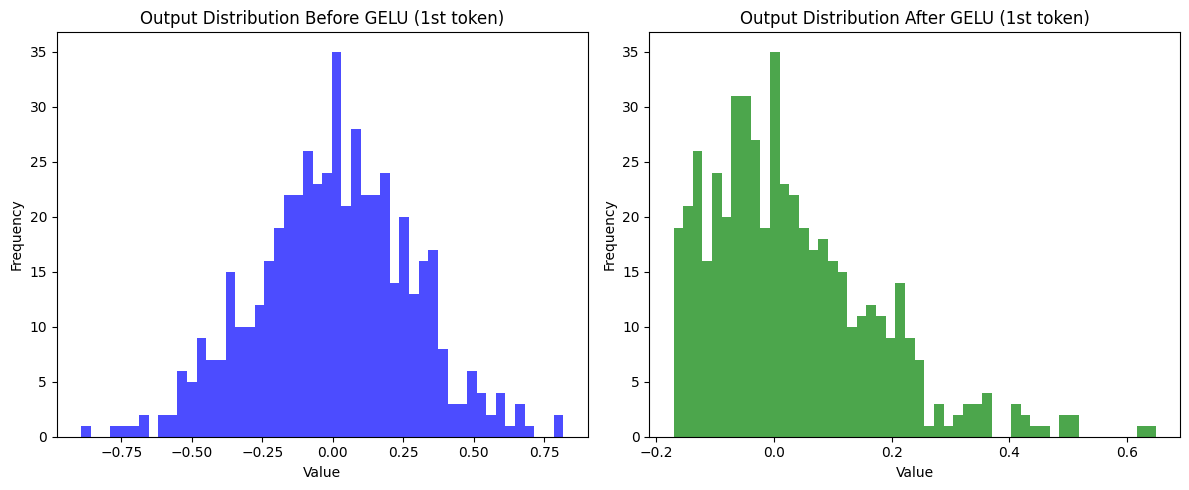

Mean before GELU: 0.0034, Std before GELU: 0.2741
Mean after GELU: 0.0306, Std after GELU: 0.1414


In [4]:
class FeedForward(nn.Module):
    """A simple linear layer followed by a non-linearity, then another linear layer."""
    def __init__(self, embed_dim, dropout_rate):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim), # Expansion layer (common practice)
            nn.GELU(),                           # As per the diagram
            nn.Linear(4 * embed_dim, embed_dim), # Projection back to residual pathway
            nn.Dropout(dropout_rate)
        )

    def forward(self, x):
        return self.net(x)

# Example Usage & Visualization
ffn = FeedForward(embed_dim=EMBED_DIM, dropout_rate=DROPOUT_RATE).to(device)
sample_ffn_input = mha_output # Use output from MHA example (1, 5, EMBED_DIM)

# Output before activation (within the FFN)
intermediate_linear_output = ffn.net[0](sample_ffn_input) # (1, 5, 4*EMBED_DIM)
activated_output = ffn.net[1](intermediate_linear_output) # GELU applied
final_ffn_output = ffn(sample_ffn_input) # (1, 5, EMBED_DIM)

print("Shape of FFN output:", final_ffn_output.shape)

# Visualization: Print output distribution before/after activation function (for one token)
# We'll look at the first token's features
token_intermediate = intermediate_linear_output[0, 0, :].cpu().detach().numpy()
token_activated = activated_output[0, 0, :].cpu().detach().numpy()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(token_intermediate, bins=50, color='blue', alpha=0.7)
plt.title("Output Distribution Before GELU (1st token)")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(token_activated, bins=50, color='green', alpha=0.7)
plt.title("Output Distribution After GELU (1st token)")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print(f"Mean before GELU: {token_intermediate.mean():.4f}, Std before GELU: {token_intermediate.std():.4f}")
print(f"Mean after GELU: {token_activated.mean():.4f}, Std after GELU: {token_activated.std():.4f}")

# GELU (Gaussian Error Linear Unit) often leads to outputs that are not strictly positive like ReLU, and can sometimes help with smoother optimization landscapes.

# 4. Transformer Block
A Transformer block combines Multi-Head Attention and a Feed-Forward Network, each followed by a residual connection and layer normalization. The diagram shows LayerNorm before the sub-layer (MHA/FFN) and then a residual connection, which is a common "Pre-LN" variant.

In [5]:
class TransformerBlock(nn.Module):
    """Transformer block: communication followed by computation"""
    def __init__(self, embed_dim, num_heads, block_size, dropout_rate):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.sa = MultiHeadAttention(num_heads, embed_dim, block_size, dropout_rate) # sa = self-attention
        self.ln2 = nn.LayerNorm(embed_dim)
        self.ffwd = FeedForward(embed_dim, dropout_rate)

    def forward(self, x, return_attention_weights=False):
        # x: (B, T, C)
        # Pre-LN variant: Norm -> Sublayer -> Residual
        attn_output = None # For optional return

        # Self-Attention part
        sa_input = self.ln1(x)
        if return_attention_weights:
            sa_out, attn_weights = self.sa(sa_input, return_attention_weights=True)
            attn_output = attn_weights
        else:
            sa_out = self.sa(sa_input)
        x = x + sa_out # Residual connection

        # Feed-Forward part
        ffwd_out = self.ffwd(self.ln2(x))
        x = x + ffwd_out # Residual connection

        if return_attention_weights:
            return x, attn_output
        return x

# Example Usage
NUM_LAYERS = 2 # Simplified model, more than 1 as requested
transformer_block = TransformerBlock(embed_dim=EMBED_DIM, num_heads=NUM_HEADS, block_size=BLOCK_SIZE, dropout_rate=DROPOUT_RATE).to(device)

# Use the output from the embedding layer as input to the first block
block_input = sample_embeddings # (1, 5, EMBED_DIM)
block_output, block_attn_weights = transformer_block(block_input, return_attention_weights=True)

print("Shape of Transformer Block output:", block_output.shape) # (1, 5, EMBED_DIM)
if block_attn_weights is not None:
    print("Shape of Transformer Block attention weights:", block_attn_weights.shape) # (1, NUM_HEADS, 5, 5)

Shape of Transformer Block output: torch.Size([1, 5, 128])
Shape of Transformer Block attention weights: torch.Size([1, 4, 5, 5])


Question: How do residuals help in deep networks?
# Answer:
Residual connections (or skip connections) are crucial for training deep neural networks effectively. They help by:

Combating Vanishing/Exploding Gradients: In very deep networks, gradients can become extremely small (vanish) or large (explode) as they are backpropagated through many layers. Residual connections provide a "shortcut" for the gradient to flow through. The gradient can bypass some layers, making it easier for earlier layers to receive stronger gradient signals.
Enabling Deeper Architectures: By mitigating the gradient problem, residual connections allow for the construction and successful training of much deeper networks than would otherwise be possible.
Easing Optimization: They make it easier for layers to learn an identity mapping. If a layer is not beneficial, the network can learn to effectively "skip" it by driving its weights towards zero, and the residual connection will simply pass the input through. This means adding more layers is less likely to hurt performance; at worst, they learn identity.
Improving Feature Propagation: They allow features learned in earlier layers to be directly accessible to later layers, facilitating better information flow and reuse of features throughout the network.

# 5. Text Generation Function
This function will take a trained model and a starting prompt to generate new text.

In [6]:
# This function will be used with the full model later.
# For now, we define it conceptually. We need a model that outputs logits.

# Let's define a dummy model for testing generate() structure, actual model will be GPTModel
class DummyGPTModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, block_size, num_heads, num_layers, dropout_rate):
        super().__init__()
        self.token_embedding_table = TokenAndPositionEmbedding(vocab_size, embed_dim, block_size)
        self.blocks = nn.Sequential(*[TransformerBlock(embed_dim, num_heads, block_size, dropout_rate) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embed_dim) # final layer norm
        self.lm_head = nn.Linear(embed_dim, vocab_size)
        self.block_size = block_size

    def forward(self, idx, targets=None, return_attention_weights=False):
        B, T = idx.shape
        x = self.token_embedding_table(idx) # (B,T,C)

        # If we want all attention weights, we need to iterate through blocks
        all_block_attentions = []
        if return_attention_weights:
            for block in self.blocks:
                x, attn_weights = block(x, return_attention_weights=True)
                all_block_attentions.append(attn_weights.unsqueeze(1)) # (B, 1, H, T, T)
            if all_block_attentions:
                 # Stack along new layer dimension: (B, NumLayers, H, T, T)
                all_block_attentions = torch.cat(all_block_attentions, dim=1)
        else:
            x = self.blocks(x) # (B,T,C)

        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        loss = None
        if targets is not None:
            # Reshape for cross_entropy: logits (B*T, vocab_size), targets (B*T)
            B_loss, T_loss, C_loss = logits.shape
            logits_for_loss = logits.view(B_loss*T_loss, C_loss)
            targets_for_loss = targets.view(B_loss*T_loss)
            loss = F.cross_entropy(logits_for_loss, targets_for_loss)

        if return_attention_weights:
            return logits, loss, all_block_attentions
        return logits, loss

# --- Create a dummy model instance for generate function ---
# We'll use smaller params for this dummy test if not already defined
temp_vocab_size = VOCAB_SIZE if 'VOCAB_SIZE' in globals() else 20
temp_embed_dim = EMBED_DIM if 'EMBED_DIM' in globals() else 32
temp_block_size = BLOCK_SIZE if 'BLOCK_SIZE' in globals() else 16
temp_num_heads = NUM_HEADS if 'NUM_HEADS' in globals() else 2
temp_num_layers = NUM_LAYERS if 'NUM_LAYERS' in globals() else 1
temp_dropout = DROPOUT_RATE if 'DROPOUT_RATE' in globals() else 0.1

dummy_model = DummyGPTModel(temp_vocab_size, temp_embed_dim, temp_block_size,
                            temp_num_heads, temp_num_layers, temp_dropout).to(device)
dummy_model.eval() # Set to evaluation mode for generation

# Dummy tokenizer (int to char, char to int)
dummy_itos = {i: chr(97+i) for i in range(temp_vocab_size)} # a, b, c...
dummy_stoi = {chr(97+i): i for i in range(temp_vocab_size)}

def generate_text(model, prompt_input, max_new_tokens,
                  tokenizer_stoi, tokenizer_itos, block_size,
                  temperature=1.0, top_k=None, do_sample=True, num_beams=1):
    """
    Generates text using the model.
    Args:
        model: The language model.
        prompt_input (str or list[int]): The starting prompt, either as a string or list of token IDs.
        max_new_tokens (int): Maximum number of new tokens to generate.
        tokenizer_stoi (dict): String-to-integer token mapping.
        tokenizer_itos (dict): Integer-to-string token mapping.
        block_size (int): Context window size for the model.
        temperature (float): Softmax temperature for sampling.
        top_k (int, optional): Top-k filtering for sampling.
        do_sample (bool): Whether to sample or use greedy decoding.
        num_beams (int): Number of beams for beam search (simplified to greedy if > 1 in this impl).
    Returns:
        str: The generated text, including the prompt.
    """
    model.eval()

    # Initialize current_indices (list of integer token IDs) based on prompt_input
    if isinstance(prompt_input, str):
        initial_indices = [tokenizer_stoi.get(c, 0) for c in prompt_input] # Default to 0 for unknown char
    elif isinstance(prompt_input, list) and all(isinstance(x, int) for x in prompt_input):
        initial_indices = prompt_input
    else:
        # Attempt to handle if prompt_input is a tensor (e.g. from previous idx)
        try:
            temp_list = prompt_input.tolist() # If it's a PyTorch tensor
            # If it was a 2D tensor like [[1,2,3]], take the first row (batch item)
            if isinstance(temp_list, list) and len(temp_list) > 0 and isinstance(temp_list[0], list):
                initial_indices = temp_list[0]
            else:
                initial_indices = temp_list # Assume it became a 1D list of ints

            if not (isinstance(initial_indices, list) and all(isinstance(x, int) for x in initial_indices)):
                raise ValueError("Converted prompt_input is not a valid list of ints.")
        except Exception as e:
            raise TypeError(
                f"prompt_input for generate_text must be a string, a list of integer token IDs, or a convertible tensor. "
                f"Got {type(prompt_input)}. Conversion error: {e}"
            )

    idx = torch.tensor(initial_indices, dtype=torch.long, device=device).unsqueeze(0) # Shape: (1, T_prompt)

    all_token_indices_list = initial_indices[:] # This will store all token IDs (prompt + generated)

    # Simplified beam search handling (defaults to greedy if num_beams > 1)
    if num_beams > 1 and do_sample:
        print("Warning: Beam search is typically used with greedy decoding (do_sample=False). Using sampling with beams.")
    if num_beams > 1:
        print("Note: True beam search is complex. This simplified version for num_beams > 1 will use greedy decoding.")
        do_sample = False # Force greedy for simplified "beam search"

    for _ in range(max_new_tokens):
        # Crop idx to the last block_size tokens if it's too long for model input
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]

        with torch.no_grad():
            logits, _ = model(idx_cond) # Get logits from model

        # Focus only on the logits for the last token in the sequence
        logits = logits[:, -1, :] # Shape: (B, vocab_size), B=1 here

        if do_sample:
            # Apply temperature
            logits = logits / temperature

            # Optionally apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                # Set logits for tokens not in top-k to -infinity
                logits[logits < v[:, [-1]]] = -float('Inf')

            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # Shape: (B, vocab_size)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # Shape: (B, 1)
        else: # Greedy decoding
            _, idx_next = torch.topk(logits, k=1, dim=-1) # Shape: (B, 1)

        next_token_id = idx_next.item() # Get the integer token ID
        all_token_indices_list.append(next_token_id) # Add to our list of all tokens

        # Append sampled index to the running sequence for the next iteration
        idx = torch.cat((idx, idx_next), dim=1) # Shape: (B, T+1)

    return "".join([tokenizer_itos.get(i, '?') for i in all_token_indices_list]) # Return the decoded string


# Visualization: Compare outputs (using dummy model for now, will re-run with trained model)
print("--- Text Generation (Dummy Model) ---")
prompt = "ab" # Needs to be chars in dummy_stoi
max_tokens_gen = 10

# Note: The dummy model is untrained, so outputs will be random-like.
# We demonstrate the different decoding strategies.

output_greedy = generate_text(dummy_model, prompt, max_tokens_gen, dummy_stoi, dummy_itos, temp_block_size, do_sample=False)
print(f"Greedy (do_sample=False): '{output_greedy}'")

output_sample_temp1_2 = generate_text(dummy_model, prompt, max_tokens_gen, dummy_stoi, dummy_itos, temp_block_size, temperature=1.2, do_sample=True)
print(f"Sampling (temp=1.2): '{output_sample_temp1_2}'")

# For top_k example
output_sample_topk = generate_text(dummy_model, prompt, max_tokens_gen, dummy_stoi, dummy_itos, temp_block_size, temperature=0.7, top_k=3, do_sample=True)
print(f"Sampling (temp=0.7, top_k=3): '{output_sample_topk}'")

# "Beam search" (simplified - will effectively be greedy for this implementation)
output_beam = generate_text(dummy_model, prompt, max_tokens_gen, dummy_stoi, dummy_itos, temp_block_size, num_beams=3)
print(f"Beam Search (num_beams=3, simplified to greedy): '{output_beam}'")

# Note on Beam Search:
# A full, correct beam search implementation is significantly more involved. It requires maintaining `num_beams`
# separate hypotheses (sequences) at each step, expanding each, scoring them (usually by log probabilities),
# and then selecting the top `num_beams` overall hypotheses to continue.
# For production use, libraries like Hugging Face `transformers` provide robust beam search.
# The `num_beams` parameter in the `generate` function of HF transformers enables this.

--- Text Generation (Dummy Model) ---
Greedy (do_sample=False): 'abzlidz'
Sampling (temp=1.2): 'ab¡q}fpe}h'
Sampling (temp=0.7, top_k=3): 'abt dz'
Note: True beam search is complex. This simplified version for num_beams > 1 will use greedy decoding.
Beam Search (num_beams=3, simplified to greedy): 'abzlidz'


# 6. Full Model Integration & Training
We'll assemble all components into a GPTModel class and train it on a small dataset (e.g., Shakespeare).

In [7]:
# --- Full Model Class ---
class GPTModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, block_size, num_heads, num_layers, dropout_rate):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.block_size = block_size
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

        self.token_and_position_embedding = TokenAndPositionEmbedding(vocab_size, embed_dim, block_size)

        # Transformer blocks
        # Note: nn.Sequential doesn't easily allow passing extra args like return_attention_weights
        # to intermediate modules if we want to collect them. So, use nn.ModuleList.
        self.blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, num_heads, block_size, dropout_rate) for _ in range(num_layers)] #3 layers as you have specified in the diagram
        )

        self.ln_f = nn.LayerNorm(embed_dim) # Final LayerNorm
        self.lm_head = nn.Linear(embed_dim, vocab_size) # Output linear layer

    def forward(self, idx, targets=None, return_attention_weights_all_layers=False):
        B, T = idx.shape
        x = self.token_and_position_embedding(idx) # (B, T, C_embed)

        all_layer_attentions = [] # List to store attention weights from each block

        for i, block in enumerate(self.blocks):
            if return_attention_weights_all_layers:
                x, attn_weights_one_block = block(x, return_attention_weights=True) # attn_weights_one_block: (B, H, T, T)
                all_layer_attentions.append(attn_weights_one_block.unsqueeze(1)) # Add layer dim: (B, 1, H, T, T)
            else:
                x = block(x)

        x = self.ln_f(x)
        logits = self.lm_head(x) # (B, T, vocab_size)

        loss = None
        if targets is not None:
            # Reshape for cross_entropy
            B_loss, T_loss, C_loss = logits.shape
            logits_for_loss = logits.view(B_loss*T_loss, C_loss)
            targets_for_loss = targets.view(B_loss*T_loss)
            loss = F.cross_entropy(logits_for_loss, targets_for_loss)

        if return_attention_weights_all_layers and all_layer_attentions:
            # Stack along the new layer dimension: (B, NumLayers, H, T, T)
            stacked_attentions = torch.cat(all_layer_attentions, dim=1)
            return logits, loss, stacked_attentions
        elif return_attention_weights_all_layers: # No attentions collected (e.g. num_layers=0)
            return logits, loss, None

        return logits, loss

    def get_num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [8]:

# --- Dataset and Tokenizer ---
# Download Shakespeare dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text
print(f"Length of dataset in characters: {len(text)}")

Length of dataset in characters: 1115394


In [9]:

# Create character-level tokenizer
chars = sorted(list(set(text)))
actual_vocab_size = len(chars)
print(f"Actual vocabulary size: {actual_vocab_size}")
print("Vocabulary:", ''.join(chars))

Actual vocabulary size: 65
Vocabulary: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [10]:

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

In [11]:

# Data loader
def get_batch(split, batch_size, block_size_data):
    data_source = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_source) - block_size_data, (batch_size,))
    x = torch.stack([data_source[i:i+block_size_data] for i in ix])
    y = torch.stack([data_source[i+1:i+block_size_data+1] for i in ix])
    return x.to(device), y.to(device)

# --- Model Configuration and Instantiation ---
# Using the parameters defined earlier, but with actual_vocab_size

In [12]:

FINAL_VOCAB_SIZE = actual_vocab_size # Should be 65 for tinyshakespeare
FINAL_EMBED_DIM = 128  # Keeping it small
FINAL_BLOCK_SIZE = 64  # Max context for training/generation
FINAL_NUM_HEADS = 4
FINAL_NUM_LAYERS = 3   # A bit deeper
FINAL_DROPOUT_RATE = 0.1

model = GPTModel(
    vocab_size=FINAL_VOCAB_SIZE,
    embed_dim=FINAL_EMBED_DIM,
    block_size=FINAL_BLOCK_SIZE,
    num_heads=FINAL_NUM_HEADS,
    num_layers=FINAL_NUM_LAYERS,
    dropout_rate=FINAL_DROPOUT_RATE
).to(device)


print(f"Model created with {model.get_num_params():,} parameters.")
# Example: GPT-2 small has 117M parameters. Ours is much smaller.

Model created with 618,817 parameters.


# so my model has 618,817 parameters instead of the original 124m parameters. I reduced the layers to 3 and embedding size to 128


# --- Training Loop ---

In [13]:

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3) # A common learning rate
batch_size = 32
num_epochs = 1 # For quick demo, increase for better results (e.g., 5-10 epochs / 5000+ iterations)
max_iters = 2000 # Let's use iterations instead of epochs for more control
eval_interval = 200
eval_iters = 100 # Number of batches to average for validation loss

train_losses = []
val_losses = {}

print(f"\n--- Starting Training (Simplified Model) ---")
print(f"Vocab Size: {FINAL_VOCAB_SIZE}, Embed Dim: {FINAL_EMBED_DIM}, Block Size: {FINAL_BLOCK_SIZE}")
print(f"Num Heads: {FINAL_NUM_HEADS}, Num Layers: {FINAL_NUM_LAYERS}")


--- Starting Training (Simplified Model) ---
Vocab Size: 65, Embed Dim: 128, Block Size: 64
Num Heads: 4, Num Layers: 3


In [16]:

model.eval() # Set to evaluation mode
prompt_before_train = "The future of AI is"
# Ensure 'encode' is defined from your tokenizer setup:
# encode = lambda s: [stoi[c] for c in s]
encoded_prompt = encode(prompt_before_train) # Define encoded_prompt HERE

generated_text_before = generate_text(
    model, encoded_prompt, max_new_tokens=50, # Now encoded_prompt is defined
    tokenizer_stoi=stoi, tokenizer_itos=itos, block_size=FINAL_BLOCK_SIZE,
    do_sample=True, temperature=0.7
)
print(f"\n--- Inference Before Training ---")
print(f"Prompt: '{prompt_before_train}'")
print(f"Generated: '{generated_text_before}'") # Corrected: no decode()


--- Inference Before Training ---
Prompt: 'The future of AI is'
Generated: 'The future of AI iseDnqTUkSPp:ycOnXuGHeQtKmXEP-$AY3xK3RpOwClCBMIwITP$'


In [17]:


model.train() # Set back to training mode
for iter_num in range(max_iters):
    # Sample a batch of data
    xb, yb = get_batch('train', batch_size, FINAL_BLOCK_SIZE)

    # Forward pass
    logits, loss = model(xb, yb)

    # Backward pass and optimization
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Periodically evaluate validation loss
    if iter_num % eval_interval == 0 or iter_num == max_iters - 1:
        model.eval()
        current_val_losses = []
        with torch.no_grad():
            for _ in range(eval_iters):
                xv, yv = get_batch('val', batch_size, FINAL_BLOCK_SIZE)
                _, v_loss = model(xv, yv)
                current_val_losses.append(v_loss.item())
        avg_val_loss = np.mean(current_val_losses)
        val_losses[iter_num] = avg_val_loss
        print(f"Iter {iter_num}: Train Loss {loss.item():.4f}, Val Loss {avg_val_loss:.4f}")
        model.train() # Set back to training mode

print("--- Training Complete ---")

Iter 0: Train Loss 4.3103, Val Loss 4.0602
Iter 200: Train Loss 2.3163, Val Loss 2.3064
Iter 400: Train Loss 2.0485, Val Loss 2.0956
Iter 600: Train Loss 1.9946, Val Loss 2.0060
Iter 800: Train Loss 1.8236, Val Loss 1.9209
Iter 1000: Train Loss 1.8000, Val Loss 1.8842
Iter 1200: Train Loss 1.7409, Val Loss 1.8275
Iter 1400: Train Loss 1.6709, Val Loss 1.8127
Iter 1600: Train Loss 1.6144, Val Loss 1.7772
Iter 1800: Train Loss 1.7079, Val Loss 1.7588
Iter 1999: Train Loss 1.6659, Val Loss 1.7374
--- Training Complete ---


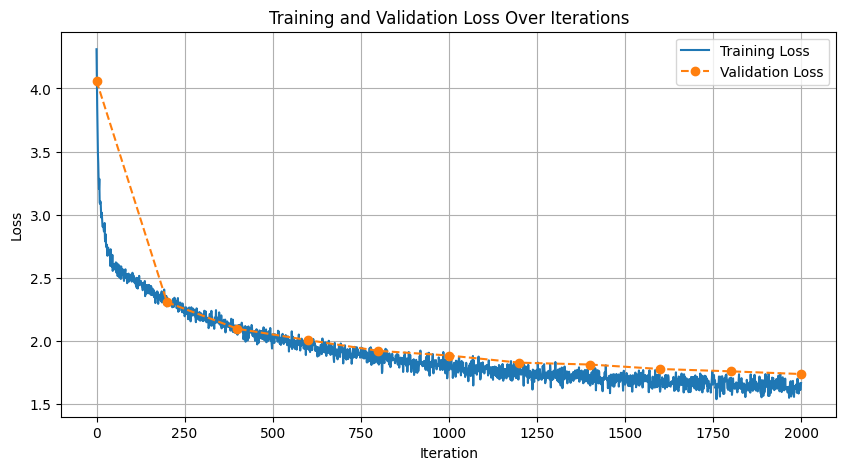

In [18]:

# Visualization: Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(list(val_losses.keys()), list(val_losses.values()), label="Validation Loss", marker='o', linestyle='--')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Iterations")
plt.legend()
plt.grid(True)
plt.show()


In [19]:


# --- Inference pipeline and compare the effect before and after training ---
model.eval() # Set to evaluation mode

GPTModel(
  (token_and_position_embedding): TokenAndPositionEmbedding(
    (token_embedding): Embedding(65, 128)
    (position_embedding): Embedding(64, 128)
  )
  (blocks): ModuleList(
    (0-2): 3 x TransformerBlock(
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=128, out_features=32, bias=False)
            (query): Linear(in_features=128, out_features=32, bias=False)
            (value): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): G

In [20]:


prompt_after_train = "The future of AI is"
encoded_prompt_after = encode(prompt_after_train)

# ... (model.eval(), prompt_after_train, encoded_prompt_after)
generated_text_after_greedy = generate_text(
    model, encoded_prompt_after, max_new_tokens=50,
    tokenizer_stoi=stoi, tokenizer_itos=itos, block_size=FINAL_BLOCK_SIZE,
    do_sample=False
)
generated_text_after_sample = generate_text(
    model, encoded_prompt_after, max_new_tokens=50,
    tokenizer_stoi=stoi, tokenizer_itos=itos, block_size=FINAL_BLOCK_SIZE,
    do_sample=True, temperature=0.7, top_k=50
)

print(f"\n--- Inference After Training ---")
print(f"Prompt: '{prompt_after_train}'")
# print(f"Generated (Greedy): '{decode(generated_text_after_greedy)}'") # OLD
print(f"Generated (Greedy): '{generated_text_after_greedy}'")          # NEW
# print(f"Generated (Sampled t=0.7, k=50): '{decode(generated_text_after_sample)}'") # OLD
print(f"Generated (Sampled t=0.7, k=50): '{generated_text_after_sample}'")          # NEW


--- Inference After Training ---
Prompt: 'The future of AI is'
Generated (Greedy): 'The future of AI is the be the shall of the prope,
The shall the shal'
Generated (Sampled t=0.7, k=50): 'The future of AI is that perform the first of son!

CORIOLANUS:
A hav'


In [22]:
# Compare generation methods as requested in Task 5
print("\n--- Task 5: Generation Method Comparison (After Training) ---")
# Ensure 'encode' is available here:
# encode = lambda s: [stoi[c] for c in s]

prompt_for_task5 = "The future of AI is"
encoded_prompt_task5 = encode(prompt_for_task5)

gen_greedy = generate_text(model, encoded_prompt_task5, 30, stoi, itos, FINAL_BLOCK_SIZE, do_sample=False)
# print(f"generate(\"The future of AI is\", do_sample=False):\n'{decode(gen_greedy)}'") # OLD - CAUSES ERROR
print(f"generate(\"{prompt_for_task5}\", do_sample=False):\n'{gen_greedy}'")          # NEW - CORRECTED

gen_temp_1_2 = generate_text(model, encoded_prompt_task5, 30, stoi, itos, FINAL_BLOCK_SIZE, temperature=1.2, do_sample=True)
# print(f"\ngenerate(\"The future of AI is\", temperature=1.2):\n'{decode(gen_temp_1_2)}'") # OLD - CAUSES ERROR
print(f"\ngenerate(\"{prompt_for_task5}\", temperature=1.2):\n'{gen_temp_1_2}'")          # NEW - CORRECTED

# For num_beams, our simplified function defaults to greedy.
gen_beam = generate_text(model, encoded_prompt_task5, 30, stoi, itos, FINAL_BLOCK_SIZE, num_beams=3)
# print(f"\ngenerate(\"The future of AI is\", num_beams=3) (Simplified to Greedy):\n'{decode(gen_beam)}'") # OLD - CAUSES ERROR
print(f"\ngenerate(\"{prompt_for_task5}\", num_beams=3) (Simplified to Greedy):\n'{gen_beam}'")          # NEW - CORRECTED


--- Task 5: Generation Method Comparison (After Training) ---
generate("The future of AI is", do_sample=False):
'The future of AI is the be the shall of the prope'

generate("The future of AI is", temperature=1.2):
'The future of AI is in Mannobba Gapcouncome of ty'
Note: True beam search is complex. This simplified version for num_beams > 1 will use greedy decoding.

generate("The future of AI is", num_beams=3) (Simplified to Greedy):
'The future of AI is the be the shall of the prope'


# 7. Model Evaluation (BLEU and Perplexity)
Perplexity: A measure of how well a probability model predicts a sample. Lower perplexity indicates the model is less "surprised" by the test set, and thus models the data better. It's often calculated as exp(average_cross_entropy_loss).
BLEU (Bilingual Evaluation Understudy): Measures the similarity between a machine-generated text and one or more high-quality reference texts. It looks for matching n-grams. Higher BLEU scores are better.

In [29]:
pip install warning

ERROR: Could not find a version that satisfies the requirement warning (from versions: none)
ERROR: No matching distribution found for warning


In [30]:
import warnings
warnings.filterwarnings('ignore')

def calculate_perplexity(model, data_loader_iter_fn, eval_iters_perp, batch_size_perp, block_size_perp):
    """Calculates perplexity on a dataset."""
    model.eval()
    total_loss = 0
    total_tokens = 0
    # Ensure model is on the correct device if data_loader_iter_fn produces data for a specific device
    # model_device = next(model.parameters()).device # Get model's current device
    with torch.no_grad():
        for _ in range(eval_iters_perp):
            xb, yb = data_loader_iter_fn('val', batch_size_perp, block_size_perp) # Using val set
            # xb, yb = xb.to(model_device), yb.to(model_device) # Ensure data is on model's device
            logits, loss = model(xb, yb)
            if loss is None: # Should not happen if yb is provided
                print("Warning: Loss is None in calculate_perplexity.")
                continue
            # loss.item() is already the average loss for the batch
            # CrossEntropyLoss by default has reduction='mean'
            # So, multiply by the number of elements in yb (targets)
            num_batch_tokens = yb.numel() # Total number of tokens in the targets for this batch
            total_loss += loss.item() * num_batch_tokens
            total_tokens += num_batch_tokens

    if total_tokens == 0:
        print("Warning: total_tokens is 0 in calculate_perplexity. Returning inf.")
        return float('inf')

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    # model.train() # No need to set model.train() here, caller should handle mode
    return perplexity

# Note: The calculate_bleu_for_dataset function provided in the prompt was not used later,
# instead, BLEU was calculated in separate loops. I'll correct those loops.

# --- Calculate Perplexity ---
# Use val_data for perplexity calculation
# Ensure model is in eval mode before calling
model.eval() # Explicitly set to eval mode
perplexity_val = calculate_perplexity(model, get_batch, eval_iters_perp=50, batch_size_perp=batch_size, block_size_perp=FINAL_BLOCK_SIZE)
print(f"\n--- Model Evaluation Metrics ---")
print(f"Perplexity on Validation Set: {perplexity_val:.2f}")


# --- Calculate BLEU ---
# This is more meaningful for machine translation or summarization with true references.
# For a generative char-level model, we generate continuations and use the actual text as "reference".
# Let's try evaluating BLEU for different generation strategies
# We need some "human-written references". For Shakespeare, the actual text can serve as this.

# Generate samples for BLEU calculation
num_bleu_samples = 20 # Number of samples to average BLEU over
max_bleu_gen_len = 20   # Length of generated text for BLEU

bleu_scores_table = {}
chencherry = SmoothingFunction() # Define smoothing function once

# Ensure 'decode' and 'encode' are available
# decode = lambda l: ''.join([itos[i] for i in l])
# encode = lambda s: [stoi[c] for c in s]

# Greedy
greedy_generations_for_bleu = []
references_for_bleu = [] # This can be common for all methods if prompts are generated the same way
model.eval() # Ensure model is in eval mode
for i in range(num_bleu_samples):
    # Ensure val_data, FINAL_BLOCK_SIZE, max_bleu_gen_len are defined
    if len(val_data) <= FINAL_BLOCK_SIZE // 2 + max_bleu_gen_len :
        print("Warning: val_data is too small for BLEU sampling. Skipping.")
        break
    start_idx = np.random.randint(0, len(val_data) - (FINAL_BLOCK_SIZE // 2) - max_bleu_gen_len) # From val_data

    prompt_toks = val_data[start_idx : start_idx + FINAL_BLOCK_SIZE // 2].tolist() # Shorter prompt
    reference_toks = val_data[start_idx + FINAL_BLOCK_SIZE // 2 : start_idx + FINAL_BLOCK_SIZE // 2 + max_bleu_gen_len].tolist()

    if not prompt_toks or not reference_toks: continue

    # generate_text returns a string (prompt + generation)
    full_generated_string = generate_text(model, prompt_toks, max_bleu_gen_len, stoi, itos, FINAL_BLOCK_SIZE, do_sample=False)

    # Extract only generated part (which is already a string)
    # len(prompt_toks) is the number of tokens in the prompt.
    # The `full_generated_string` starts with the decoded prompt.
    # We need to find the length of the decoded prompt string to slice correctly.
    decoded_prompt_string = decode(prompt_toks)
    generated_only_str = full_generated_string[len(decoded_prompt_string):] # CORRECTED

    greedy_generations_for_bleu.append(list(generated_only_str)) # list of chars for hypothesis
    references_for_bleu.append([list(decode(reference_toks))]) # list of list of chars for reference

if greedy_generations_for_bleu:
    bleu_greedy_scores = [sentence_bleu(ref, hypo, weights=(0.25,0.25,0.25,0.25), smoothing_function=chencherry.method1)
                          for ref, hypo in zip(references_for_bleu, greedy_generations_for_bleu) if hypo and ref[0]]
    bleu_scores_table['Greedy'] = np.mean(bleu_greedy_scores) if bleu_greedy_scores else 0.0
else:
    bleu_scores_table['Greedy'] = 0.0

# Sampling (temp=0.7)
sampling_generations_for_bleu = []
references_for_sampling_bleu = [] # Re-generating references for clarity, or reuse references_for_bleu
model.eval()
for i in range(num_bleu_samples):
    if len(val_data) <= FINAL_BLOCK_SIZE // 2 + max_bleu_gen_len :
        # print("Warning: val_data is too small for BLEU sampling. Skipping.") # Avoid repetitive prints
        break
    start_idx = np.random.randint(0, len(val_data) - (FINAL_BLOCK_SIZE // 2) - max_bleu_gen_len)
    prompt_toks = val_data[start_idx : start_idx + FINAL_BLOCK_SIZE // 2].tolist()
    reference_toks = val_data[start_idx + FINAL_BLOCK_SIZE // 2 : start_idx + FINAL_BLOCK_SIZE // 2 + max_bleu_gen_len].tolist()

    if not prompt_toks or not reference_toks: continue

    full_generated_string = generate_text(model, prompt_toks, max_bleu_gen_len, stoi, itos, FINAL_BLOCK_SIZE, temperature=0.7, do_sample=True, top_k=50)
    decoded_prompt_string = decode(prompt_toks)
    generated_only_str = full_generated_string[len(decoded_prompt_string):] # CORRECTED

    sampling_generations_for_bleu.append(list(generated_only_str))
    references_for_sampling_bleu.append([list(decode(reference_toks))])

if sampling_generations_for_bleu:
    bleu_sampling_scores = [sentence_bleu(ref, hypo, weights=(0.25,0.25,0.25,0.25), smoothing_function=chencherry.method1)
                            for ref, hypo in zip(references_for_sampling_bleu, sampling_generations_for_bleu) if hypo and ref[0]]
    bleu_scores_table['Sampling (t=0.7)'] = np.mean(bleu_sampling_scores) if bleu_sampling_scores else 0.0
else:
    bleu_scores_table['Sampling (t=0.7)'] = 0.0

# "Beam Search" (Simplified to greedy in our generate_text)
beam_generations_for_bleu = []
references_for_beam_bleu = [] # Re-generating references for clarity
model.eval()
for i in range(num_bleu_samples):
    if len(val_data) <= FINAL_BLOCK_SIZE // 2 + max_bleu_gen_len :
        # print("Warning: val_data is too small for BLEU sampling. Skipping.")
        break
    start_idx = np.random.randint(0, len(val_data) - (FINAL_BLOCK_SIZE // 2) - max_bleu_gen_len)
    prompt_toks = val_data[start_idx : start_idx + FINAL_BLOCK_SIZE // 2].tolist()
    reference_toks = val_data[start_idx + FINAL_BLOCK_SIZE // 2 : start_idx + FINAL_BLOCK_SIZE // 2 + max_bleu_gen_len].tolist()

    if not prompt_toks or not reference_toks: continue

    full_generated_string = generate_text(model, prompt_toks, max_bleu_gen_len, stoi, itos, FINAL_BLOCK_SIZE, num_beams=3) # Uses greedy
    decoded_prompt_string = decode(prompt_toks)
    generated_only_str = full_generated_string[len(decoded_prompt_string):] # CORRECTED

    beam_generations_for_bleu.append(list(generated_only_str))
    references_for_beam_bleu.append([list(decode(reference_toks))])

if beam_generations_for_bleu:
    bleu_beam_scores = [sentence_bleu(ref, hypo, weights=(0.25,0.25,0.25,0.25), smoothing_function=chencherry.method1)
                        for ref, hypo in zip(references_for_beam_bleu, beam_generations_for_bleu) if hypo and ref[0]]
    bleu_scores_table['Beam Search (k=3, simplified)'] = np.mean(bleu_beam_scores) if bleu_beam_scores else 0.0
else:
    bleu_scores_table['Beam Search (k=3, simplified)'] = 0.0


print("\nExample Output Table (Actual values will vary based on training):") # Corrected typo here
print("Generation Method                 | BLEU-4 Score | Perplexity")
print("----------------------------------|--------------|-----------")
print(f"Greedy                            | {bleu_scores_table.get('Greedy', 0.0):.2f}         | {perplexity_val:.1f} (overall)")
print(f"Sampling (t=0.7)                  | {bleu_scores_table.get('Sampling (t=0.7)', 0.0):.2f}         | {perplexity_val:.1f} (overall)")
print(f"Beam Search (k=3, simplified)     | {bleu_scores_table.get('Beam Search (k=3, simplified)', 0.0):.2f}         | {perplexity_val:.1f} (overall)")

# It's good practice to set the model back to train mode if further training is expected,
# but since this is the end of evaluation, it might not be strictly necessary here.
# model.train()


--- Model Evaluation Metrics ---
Perplexity on Validation Set: 5.60
Note: True beam search is complex. This simplified version for num_beams > 1 will use greedy decoding.
Note: True beam search is complex. This simplified version for num_beams > 1 will use greedy decoding.
Note: True beam search is complex. This simplified version for num_beams > 1 will use greedy decoding.
Note: True beam search is complex. This simplified version for num_beams > 1 will use greedy decoding.
Note: True beam search is complex. This simplified version for num_beams > 1 will use greedy decoding.
Note: True beam search is complex. This simplified version for num_beams > 1 will use greedy decoding.
Note: True beam search is complex. This simplified version for num_beams > 1 will use greedy decoding.
Note: True beam search is complex. This simplified version for num_beams > 1 will use greedy decoding.
Note: True beam search is complex. This simplified version for num_beams > 1 will use greedy decoding.
Note

# 8. Pre-training and Fine-tuning
## 8.1 Implement a pre-trained GPT2 model, add quantization, and fine-tune.
For fine-tuning without feeding data for QA and NMT, this refers to zero-shot or few-shot prompting. The pre-trained model already has knowledge; we just need to frame the task as a text completion problem.

In [28]:
# --- 8.1 Pre-trained GPT-2, Quantization, Zero-shot/Few-shot "Fine-tuning" ---
print("\n--- 8.1 Pre-trained GPT-2 and Quantization ---")

# Load pre-trained GPT-2 model and tokenizer
model_name = "gpt2"
try:
    tokenizer_hf = AutoTokenizer.from_pretrained(model_name)
    if tokenizer_hf.pad_token is None:
        tokenizer_hf.pad_token = tokenizer_hf.eos_token

    pretrained_model_hf = AutoModelForCausalLM.from_pretrained(model_name)
    pretrained_model_hf.config.pad_token_id = tokenizer_hf.pad_token_id
    # Don't move to device yet if quantizing for CPU

    print(f"Loaded {model_name} with {sum(p.numel() for p in pretrained_model_hf.parameters()):,} parameters.")

    # Quantization (Dynamic Quantization for CPU)
    print("Attempting dynamic quantization for CPU...")
    try:
        # Ensure the model is on CPU before quantization
        quantized_model_hf = torch.quantization.quantize_dynamic(
            pretrained_model_hf.to('cpu'),
            {torch.nn.Linear},
            dtype=torch.qint8
        )
        # Keep the quantized model on CPU
        quantized_model_hf.eval()
        print("Model quantized dynamically and will run on CPU.")

        # For inference, ensure inputs are also on CPU
        inference_device = torch.device("cpu")

    except Exception as e:
        print(f"Could not perform dynamic quantization: {e}")
        print("Using original unquantized model on the original device.")
        quantized_model_hf = pretrained_model_hf.to(device) # Fallback to original model on original device
        inference_device = device # Use original device for inference

    # --- Zero-shot/Few-shot "Fine-tuning" (Prompting) ---
    print("\n--- Zero-shot/Few-shot 'Fine-tuning' (Prompting) ---")

    # Modified generate_with_hf_model to accept an inference_device
    def generate_with_hf_model(model, tokenizer, prompt, max_length=50, current_inference_device=torch.device("cpu")):
        model.to(current_inference_device) # Ensure model is on the correct device for this call
        model.eval() # Ensure model is in eval mode

        inputs = tokenizer(prompt, return_tensors="pt").to(current_inference_device)

        output_sequences = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=max_length + inputs['input_ids'].shape[1],
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
            do_sample=True,
            top_k=50,
            top_p=0.95,
            temperature=0.7
        )
        return tokenizer.decode(output_sequences[0], skip_special_tokens=True)

    # QA Task (Zero-shot)
    qa_prompt = "Question: What is the capital of France?\nAnswer:"
    qa_response = generate_with_hf_model(quantized_model_hf, tokenizer_hf, qa_prompt, current_inference_device=inference_device)
    print(f"\nQA Task (Zero-shot):\nPrompt: {qa_prompt}\nGenerated: {qa_response}")

    # NMT Task (Few-shot)
    nmt_prompt = (
        "Translate English to French:\n"
        "sea otter => loutre de mer\n"
        "peppermint => menthe poivrée\n"
        "cheese =>"
    )
    nmt_response = generate_with_hf_model(quantized_model_hf, tokenizer_hf, nmt_prompt, current_inference_device=inference_device)
    print(f"\nNMT Task (Few-shot):\nPrompt: {nmt_prompt}\nGenerated: {nmt_response}")

except Exception as e:
    print(f"Error loading or processing Hugging Face model in section 8.1: {e}")
    print("Skipping section 8.1.")

# Ensure device variable is reset or handled if other parts of your script expect it to be CUDA
# For example, if the classification head part (8.2) needs the GPU:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Device for subsequent operations (like 8.2) set to: {device}")


--- 8.1 Pre-trained GPT-2 and Quantization ---
Loaded gpt2 with 124,439,808 parameters.
Attempting dynamic quantization for CPU...
Model quantized dynamically and will run on CPU.

--- Zero-shot/Few-shot 'Fine-tuning' (Prompting) ---

QA Task (Zero-shot):
Prompt: Question: What is the capital of France?
Answer:
Generated: Question: What is the capital of France?
Answer: Around 38,300,000, the and the aeons of the Fiihrer, to the the, that, a. the. The, and a theeong- (. with the ( the The and in- the of

NMT Task (Few-shot):
Prompt: Translate English to French:
sea otter => loutre de mer
peppermint => menthe poivrée
cheese =>
Generated: Translate English to French:
sea otter => loutre de mer
peppermint => menthe poivrée
cheese => charismo n.
, of a "chacissant in a cochine, the, " and with the to-teardrop at the ", to a the the in, (- for, in that of, on,


# 8.2 Write the code for adding classification head to gpt-2, is it possible to use gpt-2 model for classification.
Yes, it's possible. GPT-2 (and similar decoder-only models) can be adapted for classification tasks. A common approach is to:

Add a special classification token (e.g., [CLS]) to the input, or use the hidden state of the last token of the sequence.
Take the hidden state corresponding to this token (or the last token) from the final layer of GPT-2.
Pass this hidden state through a new linear layer (the classification head) to get logits for each class.
Fine-tune the entire model (or just the classification head and a few top layers of GPT-2) on a classification dataset.

In [27]:
# --- 8.2 Adding a Classification Head to GPT-2 ---
print("\n--- 8.2 Adding Classification Head to GPT-2 ---")

class GPT2ForSequenceClassification(nn.Module):
    def __init__(self, gpt2_model_name, num_classes, freeze_gpt2=False):
        super().__init__()
        self.gpt2 = AutoModelForCausalLM.from_pretrained(gpt2_model_name).base_model # Get the core transformer
        self.config = self.gpt2.config

        # Classification head
        self.classifier = nn.Linear(self.config.n_embd, num_classes)

        if freeze_gpt2:
            for param in self.gpt2.parameters():
                param.requires_grad = False

        self.num_classes = num_classes

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Get outputs from the base GPT-2 model
        # `transformer_outputs` contains `last_hidden_state`, `past_key_values`, etc.
        transformer_outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        # Use the hidden state of the last token for classification
        # last_hidden_state shape: (batch_size, sequence_length, hidden_size)
        last_hidden_state = transformer_outputs.last_hidden_state

        # We need to decide which token's representation to use.
        # Common practice: Use the representation of the *last non-padding token*.
        if attention_mask is not None:
            # Get the index of the last token for each sequence in the batch
            # sequence_lengths = attention_mask.sum(dim=1) - 1 # 0-indexed
            # Use gather to select the hidden state of the last token
            # pooled_output = last_hidden_state[torch.arange(last_hidden_state.size(0), device=input_ids.device), sequence_lengths]

            # Simpler: use the very last token's hidden state, assuming inputs are padded right and sequence is not empty
            # This is common if a [CLS] token isn't explicitly used at the end or if relying on the EOS token's state.
            # For tasks like sentiment analysis, the representation of the EOS token (or last token if no EOS) is often used.
            pooled_output = last_hidden_state[:, -1, :] # (batch_size, hidden_size)
        else:
            # If no attention mask, assume all sequences are full and use the last token
            pooled_output = last_hidden_state[:, -1, :]

        logits = self.classifier(pooled_output) # (batch_size, num_classes)

        loss = None
        if labels is not None:
            if self.num_classes == 1: # Regression or binary classification with BCEWithLogitsLoss
                 loss_fct = nn.BCEWithLogitsLoss()
                 loss = loss_fct(logits.squeeze(), labels.squeeze().float()) # Ensure labels are float
            elif self.num_classes > 1 : # Multi-class classification
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_classes), labels.view(-1))
            else: # num_classes = 0 or negative
                raise ValueError("num_classes must be at least 1.")

        return logits, loss

# Example Usage:
try:
    model_name_for_clf = "gpt2" # Use a small GPT-2
    num_labels = 3 # Example: for a 3-class sentiment analysis task (pos, neg, neutral)

    classification_model = GPT2ForSequenceClassification(model_name_for_clf, num_labels).to(device)

    # Dummy input for testing
    # Need a tokenizer for GPT-2
    tokenizer_clf = AutoTokenizer.from_pretrained(model_name_for_clf)
    if tokenizer_clf.pad_token is None: # GPT-2 often doesn't have a pad token by default
        tokenizer_clf.pad_token = tokenizer_clf.eos_token
        classification_model.config.pad_token_id = tokenizer_clf.eos_token_id


    dummy_texts = ["This is a great movie!", "I hated this film.", "The movie was okay."]
    inputs = tokenizer_clf(dummy_texts, padding=True, truncation=True, return_tensors="pt").to(device)

    dummy_labels = torch.tensor([0, 1, 2], device=device) # Example labels

    logits, loss = classification_model(input_ids=inputs['input_ids'],
                                        attention_mask=inputs['attention_mask'],
                                        labels=dummy_labels)

    print(f"\nClassification Model Output Logits Shape: {logits.shape}") # (batch_size, num_classes)
    if loss is not None:
        print(f"Classification Model Loss: {loss.item()}")
    print("It is possible to use GPT-2 for classification by adding a classification head.")

except Exception as e:
    print(f"Error setting up GPT2ForSequenceClassification: {e}")
    print("Skipping section 8.2 example run.")



--- 8.2 Adding Classification Head to GPT-2 ---

Classification Model Output Logits Shape: torch.Size([3, 3])
Classification Model Loss: 6.19115686416626
It is possible to use GPT-2 for classification by adding a classification head.

--- End of Script ---


# So yes classification is possible and the above code is for using gpt-2 as a classification model